# Purpose:
- Develop and run neural stretching
    - First replicate previous results from the test sessions.
    - Then run all training sessions.
    - Per volume
- Touch responses
    - All touches
    - Before and after decision.
- Population responses
    - Before sampling, during sampling, during decision, after pole down
- Distance between angles
- Distance within an angle
    - Correct, wrong, miss
- Selecting subset of neurons
    - Touch neurons, whisking neurons, reward neurons, etc.
        - Use the coding score.
            - Both absolute score (from all neurons) and relative score (from fit neurons, VE >= 0.05)


In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

base_dir = Path(r'E:\TPM\JK\h5')

expert_mice_df = pd.read_csv(base_dir / 'expert_mice.csv', index_col=0)
use_mice_df = expert_mice_df.loc[expert_mice_df['depth_matched'].astype(bool) & 
                                 ~expert_mice_df['processing_error'].astype(bool) &
                                 ((expert_mice_df.session_type == 'training') |
                                  (expert_mice_df.session_type.str.contains('test')))]

In [6]:
mouse = 25
volume = 1
top_plane = 1 if volume == 1 else 5
sessions = use_mice_df.query('mouse == @mouse and plane == @top_plane').session.unique().astype(int)
print(sessions)

[ 1  2  3  4  5  6 13 15 17 19]


In [7]:
session = 19
planes = range(top_plane, top_plane + 4)


In [80]:
# get touch response from one plane
plane = planes[0]
plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
behavior_frametime = pd.read_pickle(plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl')
roi_dir = plane_dir / f'{session:03}/plane0/roi'
ophys_frametime = pd.read_pickle(roi_dir / 'refined_frame_time.pkl')

# remove trials with errors
refined_ophys_frametime = ophys_frametime.query('remove_trial==False').reset_index(drop=True)
assert refined_ophys_frametime.remove_frame.values.sum() == 0

# merge refined_ophys_frametime and behavior_frametime
reduced_behavior_columns = np.setdiff1d(behavior_frametime.columns,np.setdiff1d(refined_ophys_frametime.columns, ['trialNum', 'frame_index']))
reduced_behavior_df = behavior_frametime[reduced_behavior_columns]
merged_df = pd.merge(refined_ophys_frametime, reduced_behavior_df, on=['trialNum', 'frame_index'], how='inner')

# Assigne pole_moving_up and pole_moving_down to the frames
# First check if all trials have correct pole up pole moving frames
# Sometimes there is no pole_moving_frame
# Just use -1 of the first pole up and +1 of pole up frame as pole_in_frame and pole_out_frame
assert not merged_df.groupby('trialNum').apply(lambda x: len(np.where(x['pole_up_frame']==1)[0])==0).any()
merged_df['pole_in_frame'] = merged_df.groupby('trialNum').apply(lambda x: x['frame_index'] == x['frame_index'].values[np.where(x['pole_up_frame']==True)[0][0]-1]).reset_index(drop=True).values
merged_df['pole_out_frame'] = merged_df.groupby('trialNum').apply(lambda x: x['frame_index'] == x['frame_index'].values[np.where(x['pole_up_frame']==True)[0][-1]+1]).reset_index(drop=True).values



In [81]:
# touch response per trial
spks = np.load(roi_dir / 'spks_reduced.npy')
iscell = np.load(roi_dir / 'iscell.npy')
cell_inds = np.where(iscell[:,0]==1)[0]
spks = spks[cell_inds,:]
assert spks.shape[1] == len(merged_df)
norm_spks = spks / spks.max(axis=1)[:,np.newaxis]
merged_df['spks_frame_ind'] = np.arange(spks.shape[1])

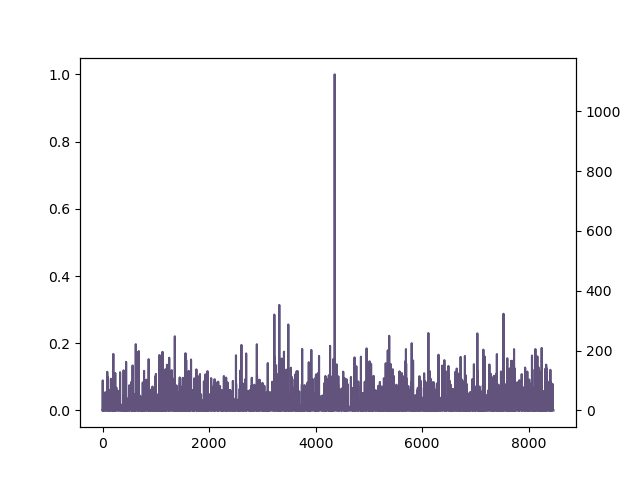

In [82]:
ci = 10
fig, ax = plt.subplots()
ax.plot(norm_spks[ci,:])
axx = ax.twinx()
axx.plot(spks[ci,:], color='r', alpha=0.3)

In [83]:
merged_df.touch_count.unique()

array([nan,  2.,  1.,  3.,  4.])

In [84]:
# touch response frames = touch frames + 0,1,2 frames
# per trial, to prevent touch rollover when pole was up till the end of the trial
def _get_touch_response_frames(x, post_touch_frames=2):
    touch_frame_inds = np.where(x['touch_count']>0)[0]    
    touch_response_frame_inds = np.unique((touch_frame_inds[:,None] + np.arange(post_touch_frames+1)).flatten())
    touch_response_frames = x['frame_index'].values[touch_response_frame_inds]
    return touch_response_frames
touch_response_frames = merged_df.groupby('trialNum').apply(_get_touch_response_frames)
touch_response_frames = np.concatenate(touch_response_frames.values)
merged_df['touch_response'] = merged_df['frame_index'].isin(touch_response_frames)

In [87]:
# QC touch_response frame (True False)
trialNums = merged_df.trialNum.unique()
merged_df[merged_df.trialNum==trialNums[30]][['frame_index', 'touch_count', 'touch_response']]

,frame_index,touch_count,touch_response
1153,1214,NaN,False
1154,1215,NaN,False
1155,1216,NaN,False
1156,1217,NaN,False
1157,1218,NaN,False
1158,1219,NaN,False
1159,1220,NaN,False
1160,1221,NaN,False
1161,1222,1.0,True
1162,1223,4.0,True


In [88]:
# Get touch response of spks per trial
touch_trial_nums = merged_df[merged_df.touch_response].trialNum.unique()

per_touch_responses = []
for tn in touch_trial_nums:
    trial_df = merged_df[merged_df.trialNum==tn]
    touch_response_frame_inds = trial_df[trial_df.touch_response].spks_frame_ind
    touch_response_spks = np.sum(norm_spks[:,touch_response_frame_inds], axis=1)
    # assert len(touch_response_spks) == norm_spks.shape[0]
    num_touch = np.nansum(trial_df.touch_count.values)
    per_touch_responses.append(touch_response_spks / num_touch)

per_touch_response_df = pd.DataFrame({'trialNum': touch_trial_nums, 'per_touch_response': per_touch_responses})
len(per_touch_response_df)

200

In [89]:
per_touch_response_df = pd.merge(per_touch_response_df, merged_df[['trialNum', 'pole_angle', 'correct', 'wrong', 'miss']].drop_duplicates(), on='trialNum', how='inner')
len(per_touch_response_df)

200

(200, 97)
(20, 97)
(28, 97)
(19, 97)
(57, 97)
(21, 97)
(23, 97)
(32, 97)


Text(0.5, 0, 'PC3')

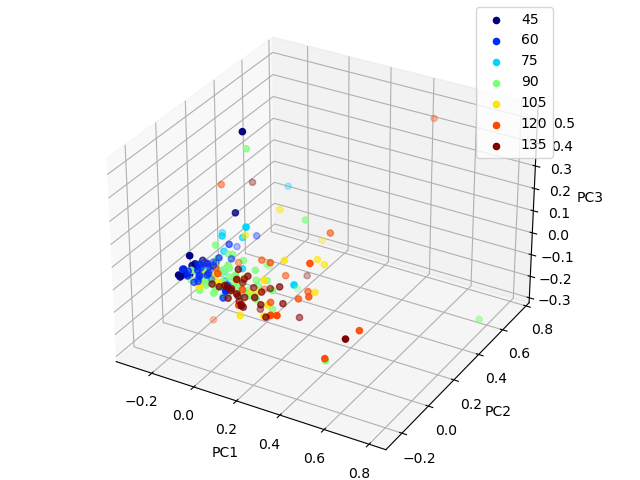

In [90]:
# run PCA on responses

responses_all = per_touch_response_df.per_touch_response.values
responses_all = np.stack(responses_all)
print(responses_all.shape)
pca = PCA(n_components=3)
pca.fit(responses_all)
# plot the 3d results
%matplotlib widget
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

angles = np.unique(per_touch_response_df.pole_angle)
colors = plt.cm.jet(np.linspace(0,1,len(angles)))
for ai, angle in enumerate(angles):
    responses_angle = per_touch_response_df[per_touch_response_df.pole_angle==angle].per_touch_response.values
    responses_angle = np.stack(responses_angle)
    print(responses_angle.shape)
    pc = pca.transform(responses_angle)
    ax.scatter(pc[:,0], pc[:,1], pc[:,2], color=colors[ai], label=angle)
ax.legend()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')


In [11]:
# look at the volume data
def get_merged_df(ophys_frametime, behavior_frametime):
    # remove trials with errors
    refined_ophys_frametime = ophys_frametime.query('remove_trial==False')
    assert refined_ophys_frametime.remove_frame.values.sum() == 0

    # merge refined_ophys_frametime and behavior_frametime
    reduced_behavior_columns = np.setdiff1d(behavior_frametime.columns,
                                            np.setdiff1d(refined_ophys_frametime.columns,
                                                         ['trialNum', 'frame_index']))
    reduced_behavior_df = behavior_frametime[reduced_behavior_columns]
    merged_df = pd.merge(refined_ophys_frametime, reduced_behavior_df,
                         on=['trialNum', 'frame_index'], how='inner')
    return merged_df


def assign_pole_moving_frames(merged_df):
    # Assigne pole_moving_up and pole_moving_down to the frames
    # First check if all trials have correct pole up pole moving frames
    # Sometimes there is no pole_moving_frame
    # Just use -1 of the first pole up and +1 of pole up frame as pole_in_frame and pole_out_frame
    
    merged_df = merged_df.query('trial_type != "oo"').reset_index(drop=True)
    assert not merged_df.groupby('trialNum').apply(lambda x: len(np.where(x['pole_up_frame'] == 1)[0]) == 0).any()
    values_to_assign = merged_df.groupby('trialNum').apply(
        lambda x: x['frame_index'] == x['frame_index'].values[np.where(x['pole_up_frame'] == 1)[0][0] - 1]).reset_index(
        drop=True).values
    assert len(values_to_assign) == len(merged_df)
    merged_df['pole_in_frame'] = values_to_assign
    values_to_assign = merged_df.groupby('trialNum').apply(apply_pole_out).reset_index(
            drop=True).values
    assert len(values_to_assign) == len(merged_df)
    merged_df['pole_out_frame'] = values_to_assign

    return merged_df


def apply_pole_out(x):
     '''Apply pole_out_frame to the merged_df
     It is the last frame of pole_up_frame.
     It should be when pole out sound cue is on.
     If it stayed up till the end, then it is ambiguous, so don't apply it.
     '''
     if np.where(x['pole_up_frame']==True)[0][-1] < len(x)-1:
          return (x['frame_index'] == x['frame_index'].values[np.where(x['pole_up_frame']==1)[0][-1]]).reset_index(drop=True)
     else:
          return pd.Series([False]*len(x))


def assign_touch_response_frames(merged_df, post_touch_frames=1):
    # get touch response frames
    # add before_answer_touch_frame and after_answer_touch_frame
    touch_response_frames = merged_df.groupby('trialNum').apply(lambda x: _get_touch_response_frames(x,post_touch_frames=post_touch_frames))
    touch_response_frames = np.concatenate(touch_response_frames.values)
    values_to_assign = merged_df['frame_index'].isin(touch_response_frames).values
    assert len(values_to_assign) == len(merged_df)
    merged_df['touch_response_frame'] = values_to_assign
    merged_df['before_answer_touch_frame'] = False
    merged_df = merged_df.groupby('trialNum').apply(_get_before_answer_touch_frames)
    merged_df['after_answer_touch_frame'] = False
    merged_df = merged_df.groupby('trialNum').apply(_get_after_answer_touch_frames)
    return merged_df


def _get_touch_response_frames(x, post_touch_frames=1):
    # touch response frames = touch frames + 0,1,2 frames
    # per trial, to prevent touch rollover when pole was up till the end of the trial
    touch_frame_inds = np.where(x['touch_count']>0)[0]    
    touch_response_frame_inds = np.unique((touch_frame_inds[:,None] + np.arange(post_touch_frames+1)).flatten())
    touch_response_frame_inds = touch_response_frame_inds[touch_response_frame_inds < len(x)]
    touch_response_frames = x['frame_index'].values[touch_response_frame_inds]
    return touch_response_frames


def _get_before_answer_touch_frames(x):    
    if np.where(x['answer_lick_frame'])[0].size == 0:
        return x
    else:
        answer_lick_frame_ind = np.where(x['answer_lick_frame'])[0][0]
        x.iloc[:answer_lick_frame_ind]['before_answer_touch_frame'] = x.iloc[:answer_lick_frame_ind]['touch_response_frame']
    return x


def _get_after_answer_touch_frames(x):
    if np.where(x['answer_lick_frame'])[0].size == 0:
        return x
    else:
        answer_lick_frame_ind = np.where(x['answer_lick_frame'])[0][0]        
        x.iloc[answer_lick_frame_ind+1:]['after_answer_touch_frame'] = x.iloc[answer_lick_frame_ind+1:]['touch_response_frame']
    return x


def get_touch_response(mouse, session, plane, spk_norm='std', post_touch_frames=1):
    plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
    behavior_frametime = pd.read_pickle(plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl')
    roi_dir = plane_dir / f'{session:03}/plane0/roi'
    ophys_frametime = pd.read_pickle(roi_dir / 'refined_frame_time.pkl')

    # get merged df
    merged_df = get_merged_df(ophys_frametime, behavior_frametime)
    # assign pole_moving_up and pole_moving_down to the frames
    merged_df = assign_pole_moving_frames(merged_df)

    # get spks
    norm_spks = get_normalized_spikes(roi_dir, ophys_frametime, merged_df, spk_norm=spk_norm)
    
    merged_df['spks_frame_ind'] = np.arange(norm_spks.shape[1])

    # get touch response frames
    merged_df = assign_touch_response_frames(merged_df, post_touch_frames=post_touch_frames)

    # Get touch response of spks per trial
    touch_trial_nums = merged_df[merged_df.touch_response_frame].trialNum.unique()
    merged_df = merged_df[merged_df.trialNum.isin(touch_trial_nums)]

    per_touch_responses = []
    for tn in touch_trial_nums:
        trial_df = merged_df[merged_df.trialNum==tn]
        touch_response_frame_inds = trial_df[trial_df.touch_response_frame].spks_frame_ind
        ##
        # touch_response_spks = np.sum(spks[:,touch_response_frame_inds], axis=1)
        touch_response_spks = np.sum(norm_spks[:,touch_response_frame_inds], axis=1)
        ##

        # assert len(touch_response_spks) == norm_spks.shape[0]
        num_touch = np.nansum(trial_df.touch_count.values)
        per_touch_responses.append(touch_response_spks / num_touch)
    cell_ids = [f'p{plane}c{ci:04}' for ci in norm_spks.cell_index.values]
    per_touch_response_xr = xr.DataArray(per_touch_responses,
                                         dims=['trialNum', 'cell_id'],
                                         coords={'trialNum': touch_trial_nums, 'cell_id': cell_ids})
    per_touch_response_df = merged_df[['trialNum', 'pole_angle', 'correct', 'wrong', 'miss']].drop_duplicates()
    return per_touch_response_xr, per_touch_response_df


def get_normalized_spikes(roi_dir, ophys_frametime, merged_df, spk_norm='std'):
    spks = np.load(roi_dir / 'spks_reduced.npy')
    iscell = np.load(roi_dir / 'iscell.npy')
    cell_inds = np.where(iscell[:,0]==1)[0]
    spks = spks[cell_inds,:]
    assert spks.shape[1] == len(ophys_frametime)
    # deal with mismatched length
    if len(ophys_frametime) != len(merged_df):    
        removed_inds = np.where(ophys_frametime.frame_index.isin(merged_df.frame_index) == False)[0]
        # removed_tns = ophys_frametime.iloc[removed_inds].trialNum.unique()
        # print(f'JK{mouse:03} S{session:02} plane {plane} ophys_frametime and merged_df length mismatch:')
        # print(f'{len(removed_inds)} frames, {len(removed_tns)} trials')    
        spks = np.delete(spks, removed_inds, axis=1)
    assert spks.shape[1] == len(merged_df)

    # normalize spikes
    if spk_norm == 'std':
        norm_spks = (spks - spks.mean(axis=1)[:,np.newaxis]) / spks.std(axis=1)[:,np.newaxis]
    elif spk_norm == 'max':
        norm_spks = spks / spks.max(axis=1)[:,np.newaxis]
    elif spk_norm == 'none':
        norm_spks = spks
    else:
        raise ValueError('spk_norm should be either "std", "max", or "none"')
    norm_spks = xr.DataArray(norm_spks,
                             dims=('cell_index', 'frame_index'),
                             coords={'cell_index': cell_inds, 'frame_index': merged_df.frame_index.values},
                             attrs={'event_normalization': spk_norm})
    return norm_spks

In [12]:
for pi, plane in enumerate(planes):
    per_touch_response_xr_plane, per_touch_response_df_plane = get_touch_response(mouse, session, plane)
    if pi == 0:
        per_touch_response_xr = per_touch_response_xr_plane.copy()
        per_touch_response_df = per_touch_response_df_plane.copy()
    else:
        assert per_touch_response_df.equals(per_touch_response_df_plane)
        assert per_touch_response_xr.shape[0] == per_touch_response_xr_plane.shape[0]
        assert per_touch_response_xr.trialNum.equals(per_touch_response_xr_plane.trialNum)
        per_touch_response_xr = xr.concat([per_touch_response_xr, per_touch_response_xr_plane], dim='cell_id')


Text(0, 0.5, 'PC2')

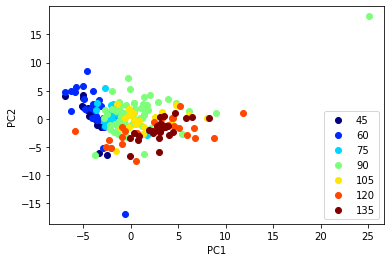

In [13]:
# Run PCA on the volume data
responses_all = per_touch_response_xr.values
pca = PCA()
pca.fit(responses_all)
%matplotlib inline
fig, ax = plt.subplots()

angles = np.unique(per_touch_response_df.pole_angle)
colors = plt.cm.jet(np.linspace(0,1,len(angles)))
for ai, angle in enumerate(angles):
    angle_tns = per_touch_response_df[per_touch_response_df.pole_angle==angle].trialNum.values
    responses_angle = per_touch_response_xr.sel(trialNum=angle_tns).values    
    pc = pca.transform(responses_angle)
    ax.scatter(pc[:,0], pc[:,1], color=colors[ai], label=angle)
ax.legend()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')


In [14]:
def get_touch_response_volume_xr(mouse, top_plane, session, spk_norm='std', post_touch_frames=1):    
    planes = range(top_plane, top_plane + 4)
    for pi, plane in enumerate(planes):
        per_touch_response_xr_plane, per_touch_response_df_plane = \
            get_touch_response(mouse, session, plane, spk_norm=spk_norm, post_touch_frames=post_touch_frames)
        if pi == 0:
            per_touch_response_xr = per_touch_response_xr_plane.copy()
            per_touch_response_df = per_touch_response_df_plane.copy()
        else:
            assert per_touch_response_df.equals(per_touch_response_df_plane)
            assert per_touch_response_xr.shape[0] == per_touch_response_xr_plane.shape[0]
            assert per_touch_response_xr.trialNum.equals(per_touch_response_xr_plane.trialNum)
            per_touch_response_xr = xr.concat([per_touch_response_xr, per_touch_response_xr_plane], dim='cell_id')

    return per_touch_response_xr, per_touch_response_df


def draw_pca_touch_response(use_mice_df, mouse, top_plane, session_type, ax, spk_norm='std', post_touch_frames=1, pcs=[0,1]):
    sessions = use_mice_df.query('mouse == @mouse and plane == @top_plane and session_type == @session_type').session.unique().astype(int)
    if len(sessions) == 0:
        return ax
    session = sessions[0]
    per_touch_response_xr, per_touch_response_df = \
        get_touch_response_volume_xr(mouse, top_plane, session,
                                     spk_norm=spk_norm, post_touch_frames=post_touch_frames)
    responses_all = per_touch_response_xr.values
    pca = PCA()
    pca.fit(responses_all)
    angles = np.unique(per_touch_response_df.pole_angle)
    colors = plt.cm.jet(np.linspace(0,1,len(angles)))
    for ai, angle in enumerate(angles):
        angle_tns = per_touch_response_df[per_touch_response_df.pole_angle==angle].trialNum.values
        responses_angle = per_touch_response_xr.sel(trialNum=angle_tns).values    
        pc = pca.transform(responses_angle)
        ax.scatter(pc[:,pcs[0]], pc[:,pcs[1]], color=colors[ai], label=angle)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.set_title(f'JK{mouse:03} Volume {volume} {session_type}')
    ax.set_xlabel(f'PC{pcs[0]+1}')
    ax.set_ylabel(f'PC{pcs[1]+1}')
    return ax

        

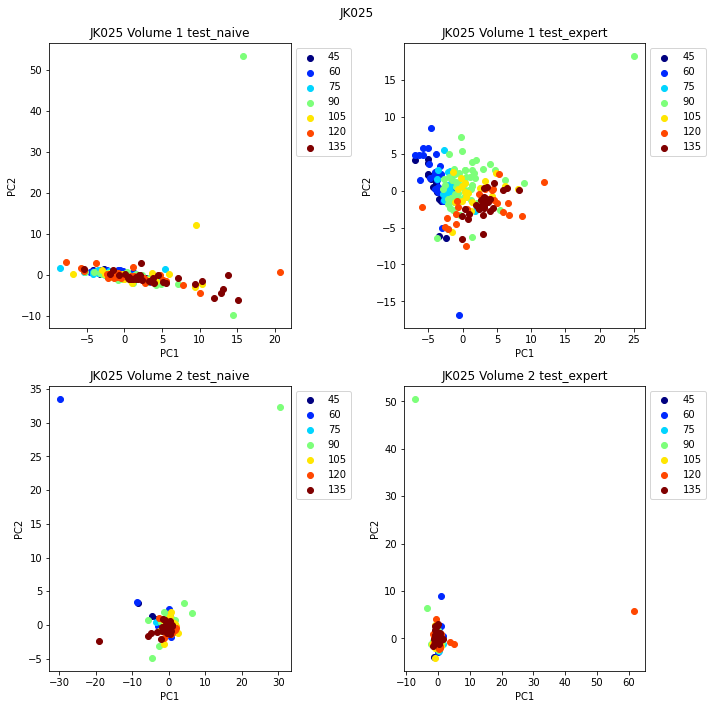

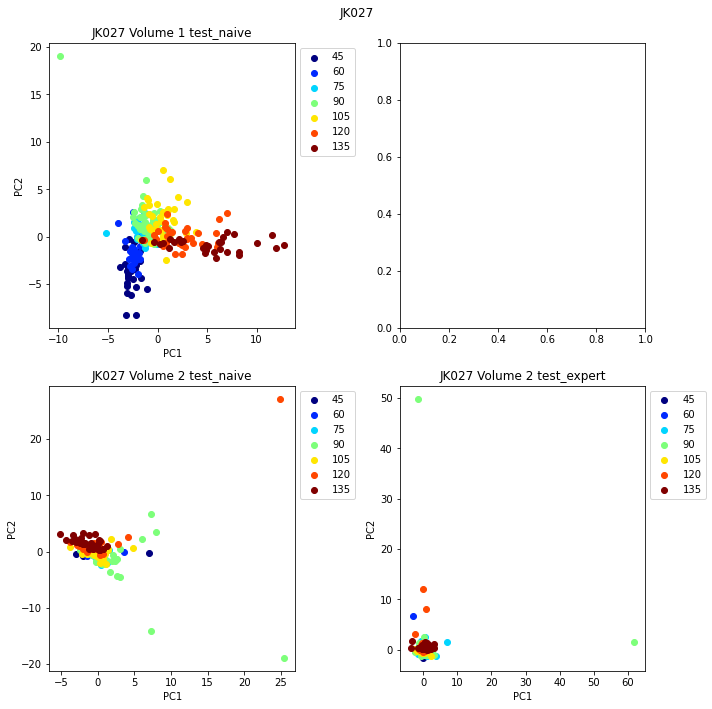

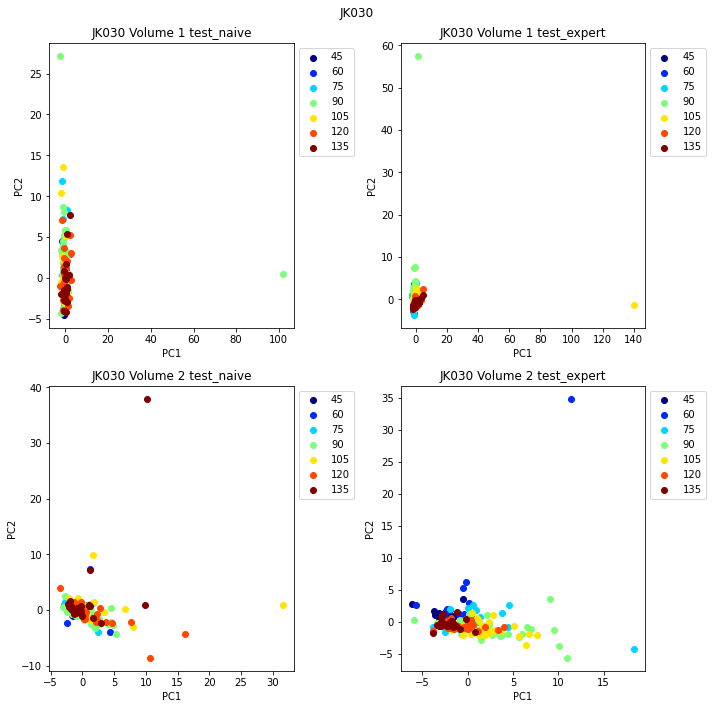

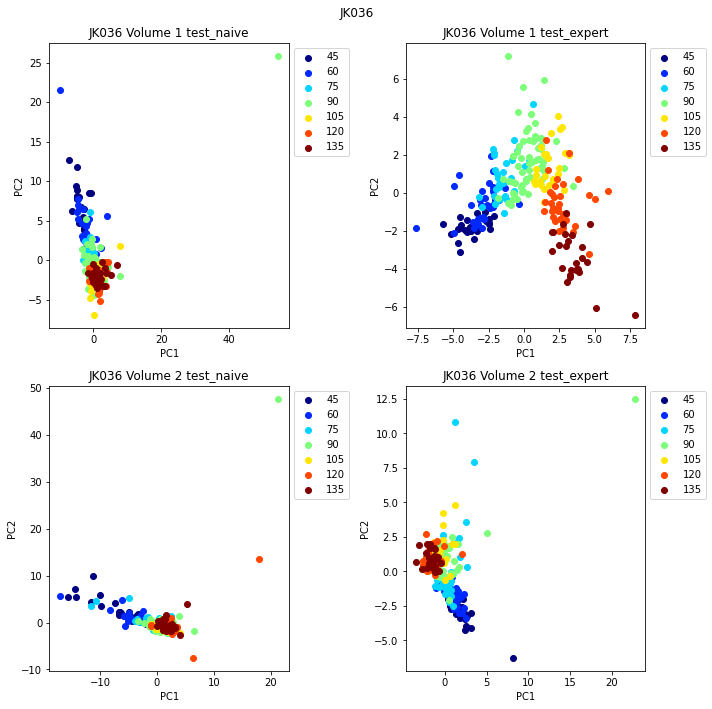

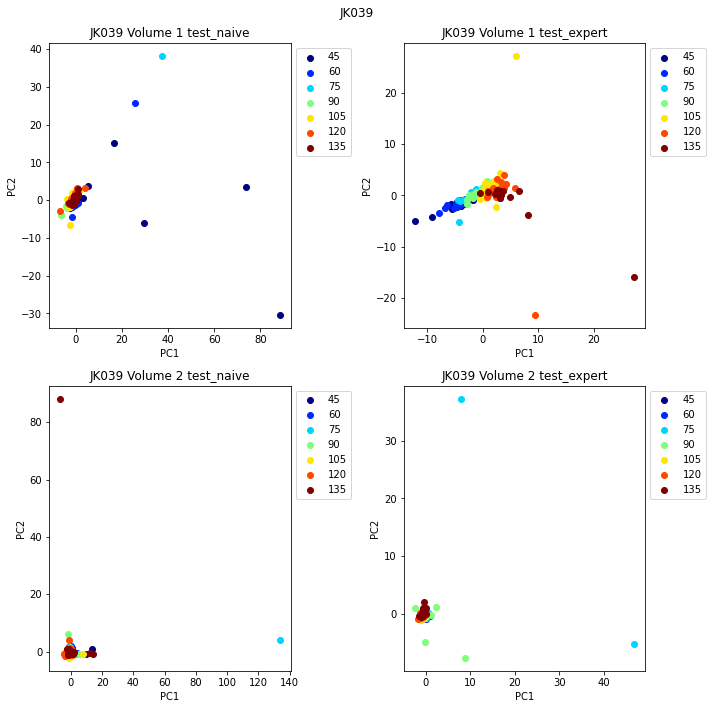

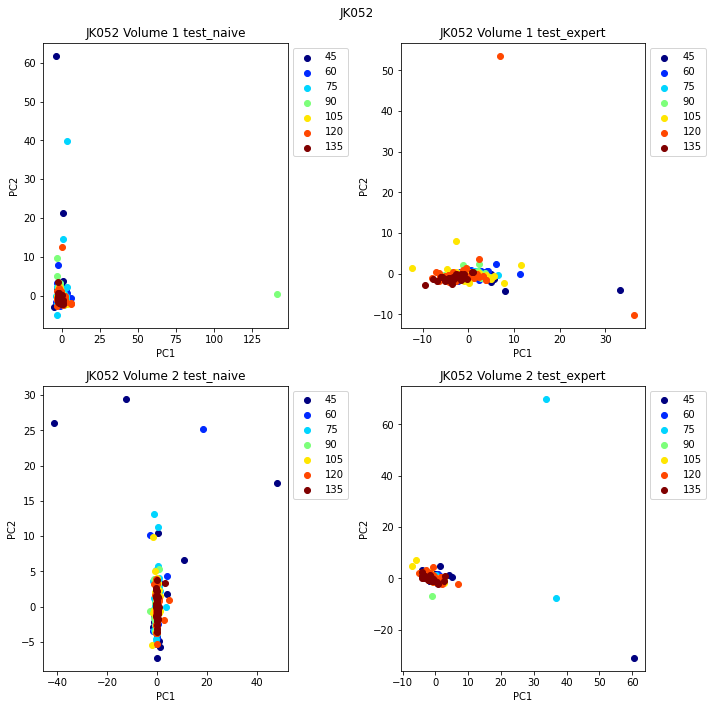

In [15]:
for mi, mouse in enumerate(use_mice_df.mouse.unique()):
    fig, ax = plt.subplots(2,2, figsize=(10,10))
    for vi in range(2):
        if vi == 0:
            volume = 1
            top_plane = 1
        else:
            volume = 2
            top_plane = 5
        draw_pca_touch_response(use_mice_df, mouse, top_plane, 'test_naive', ax[vi,0])
        draw_pca_touch_response(use_mice_df, mouse, top_plane, 'test_expert', ax[vi,1])
    fig.suptitle(f'JK{mouse:03}')
    fig.tight_layout()

# PCA conditions
- spike normalization
- touch response normalization
- activity or touch responsivity
- filter miss trials

### Try with a single example
- expert session of JK025 lower volume

In [322]:
mouse = 25
top_plane = 5
session_type = 'test_expert'
spk_norm = 'max'
sessions = use_mice_df.query('mouse == @mouse and plane == @top_plane and session_type == @session_type').session.unique().astype(int)
session = sessions[0]
per_touch_response_xr, per_touch_response_df = get_touch_response_volume_xr(mouse, top_plane, session, spk_norm=spk_norm)


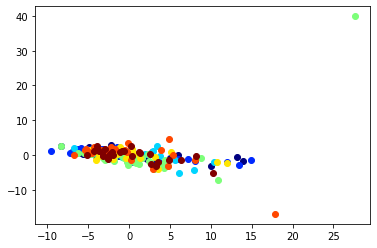

In [323]:
fig, ax = plt.subplots()
responses_all = per_touch_response_xr.values
responses_all = (responses_all - responses_all.mean(axis=0)) / responses_all.std(axis=0)
pcs = [0,1]
pca = PCA()
pca.fit(responses_all)
angles = np.unique(per_touch_response_df.pole_angle)
colors = plt.cm.jet(np.linspace(0,1,len(angles)))
for ai, angle in enumerate(angles):
    angle_tns = per_touch_response_df[per_touch_response_df.pole_angle==angle].trialNum.values
    responses_angle = per_touch_response_xr.sel(trialNum=angle_tns).values
    responses_angle = (responses_angle - responses_angle.mean(axis=0)) / responses_angle.std(axis=0)
    pc = pca.transform(responses_angle)
    ax.scatter(pc[:,pcs[0]], pc[:,pcs[1]], color=colors[ai], label=angle)

### spk normalization or response standardization did not help
- try filtering based on fit

In [328]:
per_touch_response_xr

<xarray.DataArray (trialNum: 202, cell_id: 505)>
array([[0.04141761, 0.        , 0.00727311, ..., 0.        , 0.0105234 ,
        0.02473129],
       [0.00446365, 0.14457586, 0.03723075, ..., 0.        , 0.        ,
        0.        ],
       [0.03077099, 0.        , 0.00905973, ..., 0.00410701, 0.00049171,
        0.00421588],
       ...,
       [0.04346347, 0.        , 0.00625913, ..., 0.00964641, 0.00240867,
        0.02265437],
       [0.19960973, 0.042966  , 0.00267532, ..., 0.01404023, 0.00572118,
        0.00389929],
       [0.01455027, 0.        , 0.00480643, ..., 0.00103102, 0.        ,
        0.00503732]], dtype=float32)
Coordinates:
  * trialNum  (trialNum) object 15 19 20 21 32 33 34 ... 434 435 437 438 439 440
  * cell_id   (cell_id) <U7 'p5c0000' 'p5c0001' ... 'p8c0133' 'p8c0134'

In [16]:
def get_glm_results(base_dir, mouse, plane, session):
    plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
    roi_dir = plane_dir / f'{session:03}/plane0/roi'
    glm_dir = roi_dir / 'glm/touch_combined'
    glm_result = xr.open_dataset(glm_dir / 'glm_result.nc')
    return glm_result


def get_cell_inds_varexp_threshold(per_touch_response_xr, glm_result, plane, varexp_threshold=0.05):
    # get cell ids with varexp_model_final > varexp_threshold
    cell_ids = glm_result.cell_id.values
    varexp_model_final = glm_result.varexp_model_final.values
    cell_ids = cell_ids[varexp_model_final > varexp_threshold]
    return np.where([cid in [f'p{plane}c{ci:04}' for ci in cell_ids] for cid in per_touch_response_xr.cell_id.values])[0]


def get_touch_response_xr_varexp_threshold(mouse, top_plane, session_type,
                                           spk_norm='std', varexp_threshold=0.05,
                                           post_touch_frames=2):
    session = use_mice_df.query('mouse == @mouse and plane == @top_plane and session_type == @session_type').session.unique().astype(int)[0]
    per_touch_response_xr, per_touch_response_df = get_touch_response_volume_xr(mouse, top_plane, session,
                                                                                spk_norm=spk_norm,
                                                                                post_touch_frames=post_touch_frames)
    fit_cell_inds = []
    for plane in range(top_plane, top_plane+4):
        glm_result = get_glm_results(base_dir, mouse, plane, session)
        cell_inds = get_cell_inds_varexp_threshold(per_touch_response_xr, glm_result, plane, varexp_threshold=varexp_threshold)
        fit_cell_inds.extend(cell_inds)
    per_touch_response_xr_fit = per_touch_response_xr.isel(cell_id=fit_cell_inds)
    assert len(fit_cell_inds) == per_touch_response_xr_fit.shape[1]
    return per_touch_response_xr_fit, per_touch_response_df, per_touch_response_xr

In [356]:
per_touch_response_xr_fit, per_touch_response_df, per_touch_response_xr = \
    get_touch_response_xr_varexp_threshold(mouse, top_plane, session, spk_norm=spk_norm, varexp_threshold=0.05)

In [369]:
responses_all = per_touch_response_xr.values
responses_all.mean(axis=1).shape

(202,)

In [368]:
per_touch_response_xr.dims

('trialNum', 'cell_id')

In [367]:
responses_all.shape

(202, 505)

In [17]:
def _draw_pca(response_xr, response_df, ax, standardization=True, pcs=[0,1]):
    responses_all = response_xr.values
    if standardization:
        responses_all = (responses_all - responses_all.mean(axis=0)) / responses_all.std(axis=0)
    pca = PCA()
    pca.fit(responses_all)
    angles = np.unique(response_df.pole_angle)
    colors = plt.cm.jet(np.linspace(0,1,len(angles)))
    for ai, angle in enumerate(angles):
        angle_tns = response_df[response_df.pole_angle==angle].trialNum.values
        responses_angle = response_xr.sel(trialNum=angle_tns).values
        if standardization:
            responses_angle = (responses_angle - responses_angle.mean(axis=0)) / responses_angle.std(axis=0)
        pc = pca.transform(responses_angle)
        ax.scatter(pc[:,pcs[0]], pc[:,pcs[1]], color=colors[ai], label=angle)
    return ax



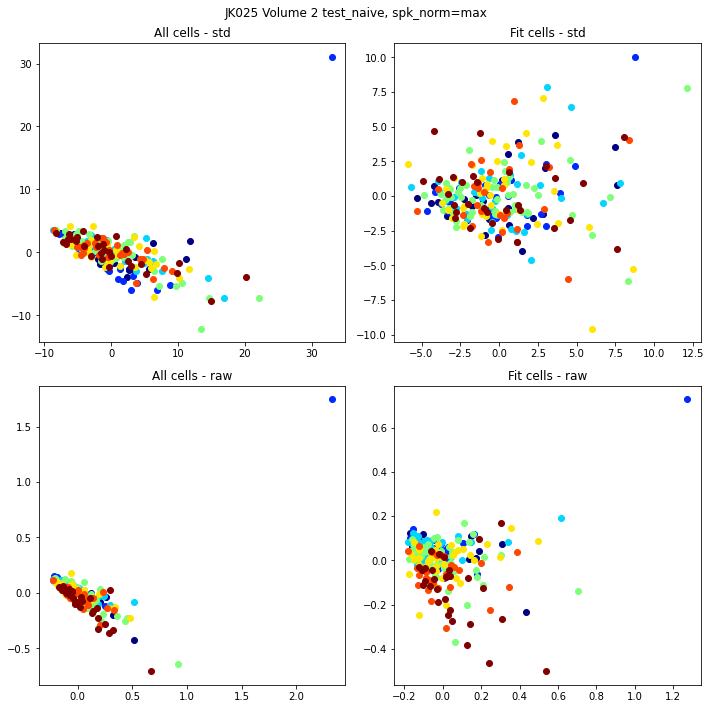

In [380]:
session_type = 'test_naive'
sessions = use_mice_df.query('mouse == @mouse and plane == @top_plane and session_type == @session_type').session.unique().astype(int)
session = sessions[0]
spk_norm = 'max'
per_touch_response_xr_fit, per_touch_response_df, per_touch_response_xr = \
    get_touch_response_xr_varexp_threshold(mouse, top_plane, session, spk_norm=spk_norm, varexp_threshold=0.05)
fig, ax = plt.subplots(2,2, figsize=(10,10))
pcs=[0,1]
_draw_pca(per_touch_response_xr, per_touch_response_df, ax[0,0], standardization=True, pcs=pcs)
ax[0,0].set_title('All cells - std')
_draw_pca(per_touch_response_xr_fit, per_touch_response_df, ax[0,1], standardization=True, pcs=pcs)
ax[0,1].set_title('Fit cells - std')
_draw_pca(per_touch_response_xr, per_touch_response_df, ax[1,0], standardization=False, pcs=pcs)
ax[1,0].set_title('All cells - raw')
_draw_pca(per_touch_response_xr_fit, per_touch_response_df, ax[1,1], standardization=False, pcs=pcs)
ax[1,1].set_title('Fit cells - raw')
fig.suptitle(f'JK{mouse:03} Volume {volume} {session_type}, spk_norm={spk_norm}')
fig.tight_layout()

### neural stretching observed when using raw touch response from fit cells, regardless of spike normalization methods. 
- But it's gone when standardizing touch responses again. 
- Why?
- First, check this across volumes

In [15]:
use_mice_df.query('mouse == @mouse and plane == @top_plane and session_type == @session_type')

,Unnamed: 0.1,mouse,plane,session,session_type,depth_matched,processing_error,remove_frame_ind
1358,1358,52,5,21,test_expert,True,False,0


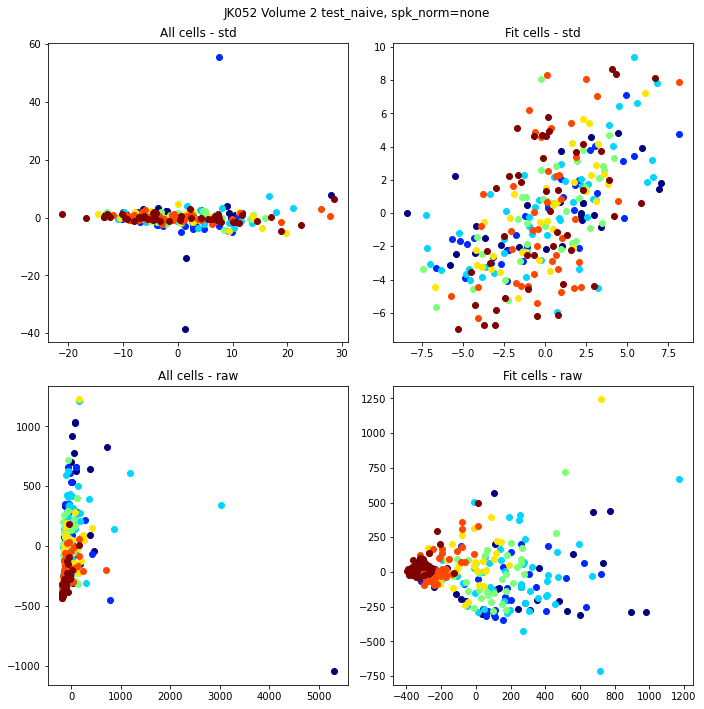

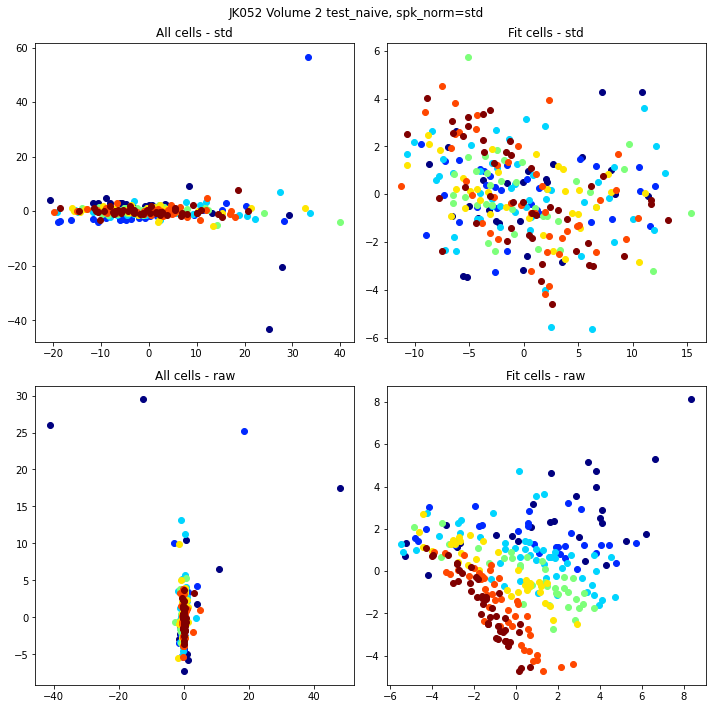

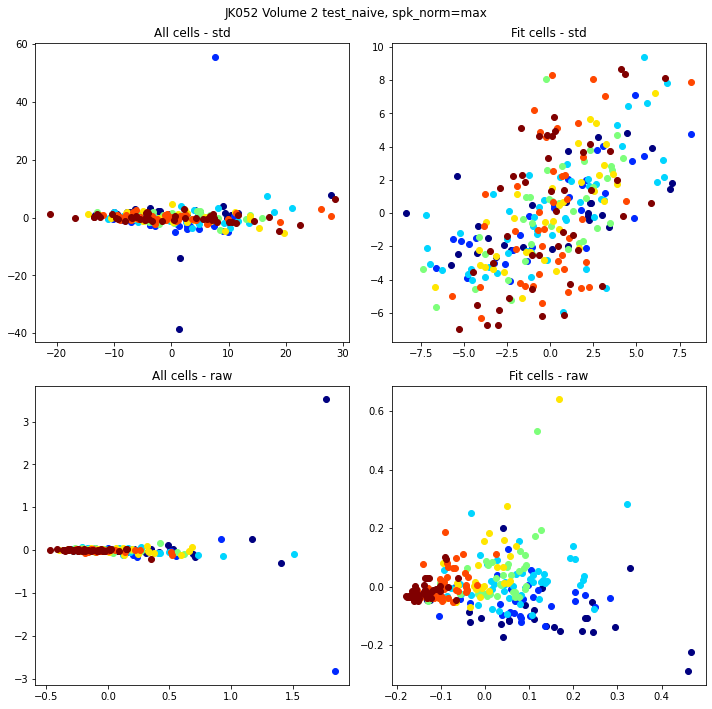

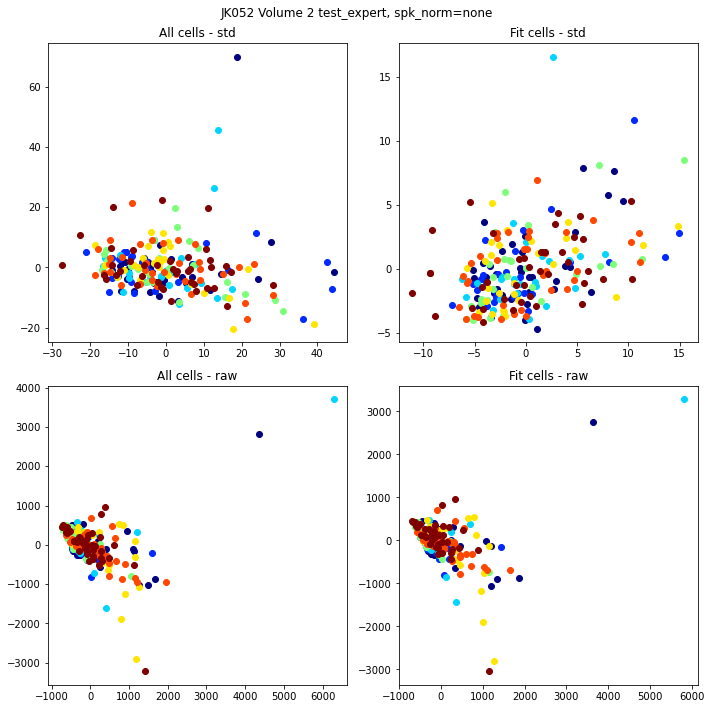

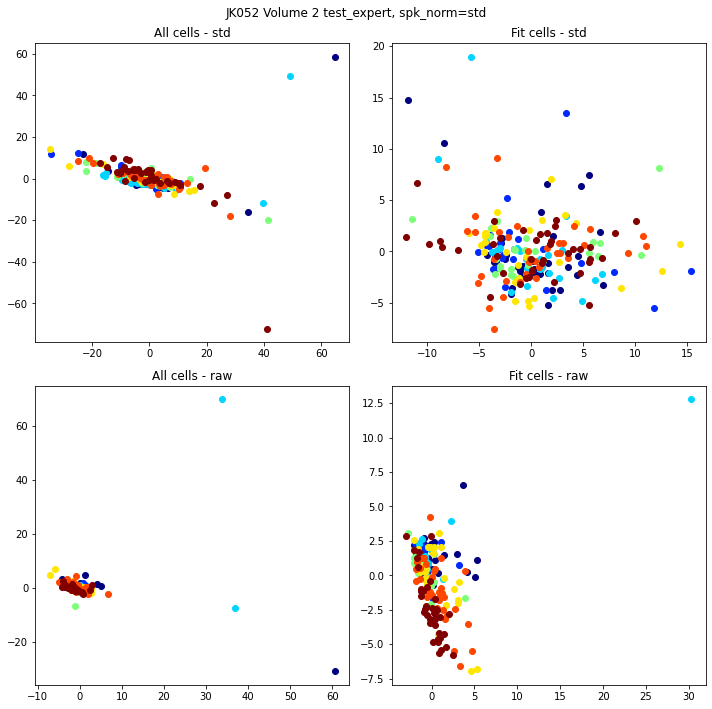

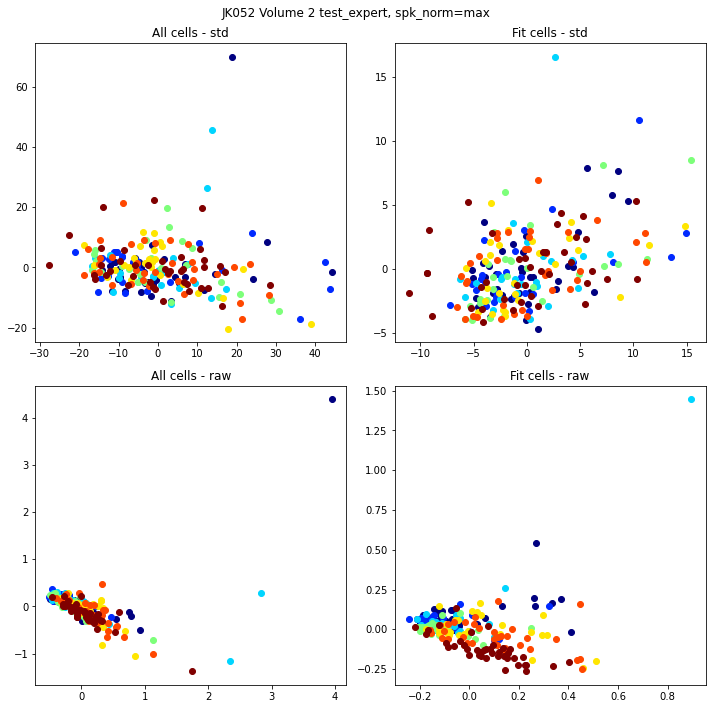

In [18]:
mouse = 52
volume = 2
post_touch_frames=1
top_plane = 1 if volume == 1 else 5
session_types = ['test_naive', 'test_expert']
spk_norms = ['none', 'std', 'max']
pcs=[0,1]
for session_type in session_types:
    for spk_norm in spk_norms:
        fig, ax = plt.subplots(2,2, figsize=(10,10))
        per_touch_response_xr_fit, per_touch_response_df, per_touch_response_xr = \
            get_touch_response_xr_varexp_threshold(mouse, top_plane, session_type, 
                                                   spk_norm=spk_norm, varexp_threshold=0.05,
                                                   post_touch_frames=post_touch_frames)
        _draw_pca(per_touch_response_xr, per_touch_response_df, ax[0,0], standardization=True, pcs=pcs)
        ax[0,0].set_title('All cells - std')
        _draw_pca(per_touch_response_xr_fit, per_touch_response_df, ax[0,1], standardization=True, pcs=pcs)
        ax[0,1].set_title('Fit cells - std')
        _draw_pca(per_touch_response_xr, per_touch_response_df, ax[1,0], standardization=False, pcs=pcs)
        ax[1,0].set_title('All cells - raw')
        _draw_pca(per_touch_response_xr_fit, per_touch_response_df, ax[1,1], standardization=False, pcs=pcs)
        ax[1,1].set_title('Fit cells - raw')
        fig.suptitle(f'JK{mouse:03} Volume {volume} {session_type}, spk_norm={spk_norm}')
        fig.tight_layout()

## Check touch response standardization
- Is this correct? why does this lead to scrambled angle response?
- test on z-scored events
- sort trials by angles

In [18]:
mouse = 25
volume = 1
top_plane = 1 if volume == 1 else 5
session_type = 'test_expert'
sessions = use_mice_df.query('mouse == @mouse and plane == @top_plane and session_type == @session_type').session.unique().astype(int)
session = sessions[0]
spk_norm = 'std'
post_touch_frames = 1
per_touch_response_xr_fit, per_touch_response_df, per_touch_response_xr = \
    get_touch_response_xr_varexp_threshold(mouse, top_plane, session_type, spk_norm=spk_norm, varexp_threshold=0.05,
                                           post_touch_frames=post_touch_frames)


In [25]:
per_touch_response_xr_fit.dims

('trialNum', 'cell_id')

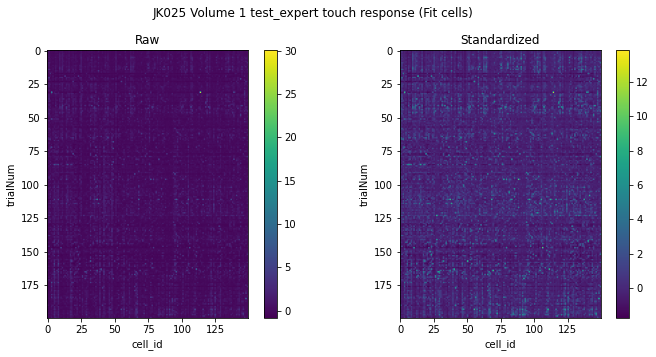

In [41]:
angles = np.sort(per_touch_response_df.pole_angle.unique())
trial_order = []
per_touch_response_fit = xr.DataArray(dims=['trialNum', 'cell_id'], coords={'trialNum': [], 'cell_id': []})
for angle in angles:
    trial_nums = per_touch_response_df.query('pole_angle == @angle').trialNum.values
    trial_order.extend(trial_nums)
    per_touch_response_fit= xr.concat([per_touch_response_fit,
                                      per_touch_response_xr_fit.sel(trialNum=trial_nums)],
                                      dim='trialNum')
per_touch_response_fit_std = (per_touch_response_fit - per_touch_response_fit.mean(dim='trialNum')) / per_touch_response_fit.std(dim='trialNum')

fig, ax = plt.subplots(1,2, figsize=(10,5))
im = ax[0].imshow(per_touch_response_fit)
cbar = fig.colorbar(im, ax=ax[0])
ax[0].set_title('Raw')
ax[0].set_xlabel(per_touch_response_fit.dims[1])
ax[0].set_ylabel(per_touch_response_fit.dims[0])
im = ax[1].imshow(per_touch_response_fit_std)
cbar = fig.colorbar(im, ax=ax[1])
ax[1].set_title('Standardized')
ax[1].set_xlabel(per_touch_response_fit_std.dims[1])
ax[1].set_ylabel(per_touch_response_fit_std.dims[0])
fig.suptitle(f'JK{mouse:03} Volume {volume} {session_type} touch response (Fit cells)')
fig.tight_layout()

### sorting cells by their tuned angle will be better.
- Come back this point after calculating angle tuning. (240224_angle_tuning_dev.ipynb)

### Compare dff, events, std events, and max-norm events.
- Choose which one to use.
- Syeda et al., 2023 used z-scored events.

# Check angle tuning 
- JK052 volume 2 & JK052 volume 2: naive neural stretching > expert

# Error sessions

In [185]:
use_mice_df.query('mouse==39')[['mouse','session','session_type']].drop_duplicates()

,mouse,session,session_type
912,39,1,test_naive
914,39,3,training
915,39,4,training
916,39,5,training
917,39,6,training
918,39,7,training
919,39,8,training
920,39,9,training
921,39,10,training
922,39,11,training


In [197]:
mouse = 39
session = 1
volume = 2
top_plane = 1 if volume == 1 else 5
planes = range(top_plane, top_plane + 4)
plane = planes[0]

# per_touch_response_xr, per_touch_response_df = get_touch_response(mouse, session, plane)

plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
behavior_frametime = pd.read_pickle(plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl')
roi_dir = plane_dir / f'{session:03}/plane0/roi'
ophys_frametime = pd.read_pickle(roi_dir / 'refined_frame_time.pkl')

# get spikes
spks = np.load(roi_dir / 'spks_reduced.npy')
iscell = np.load(roi_dir / 'iscell.npy')
cell_inds = np.where(iscell[:,0]==1)[0]
spks = spks[cell_inds,:]
assert spks.shape[1] == len(ophys_frametime)

# get merged df
merged_df = get_merged_df(ophys_frametime, behavior_frametime)

In [198]:
merged_df = assign_pole_moving_frames(merged_df)

C:\Users\shires\AppData\Local\Temp/ipykernel_35884/2689152529.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['pole_in_frame'] = merged_df.groupby('trialNum').apply(


IndexError: index 31 is out of bounds for axis 0 with size 31

In [187]:
merged_df.columns

Index(['trialNum', 'frame_start_time', 'frame_end_time', 'trial_duration',
       'frame_index', 'remove_frame', 'remove_trial', 'amplitude',
       'answer_lick_frame', 'answer_lick_left', 'answer_lick_right',
       'answer_period_frame', 'arc_length_onset', 'correct', 'delta_kappaH',
       'delta_kappaV', 'delta_phi', 'delta_theta', 'distractor',
       'first_reward_lick_frame', 'first_reward_lick_left',
       'first_reward_lick_right', 'kappaH_onset', 'kappaV_onset', 'midpoint',
       'miss', 'mouse_name', 'num_lick_left', 'num_lick_right', 'num_whisks',
       'phi_onset', 'pole_angle', 'pole_ap_distance', 'pole_moving_frame',
       'pole_radial_distance', 'pole_up_frame', 'post_answer_pole_up_frame',
       'pre_answer_pole_up_frame', 'session_name', 'session_type',
       'slide_distance', 'task_target', 'theta', 'theta_onset', 'touch_count',
       'touch_duration', 'trial_type', 'wrong'],
      dtype='object')

### Assign pole_out_frame issue
- There are some cases where pole stayed up till the end of 2p frame
- How many?
- Why did it not error for GLM?

In [199]:
# one example from JK039 S1 plane 5
mouse = 39
session = 1
plane = 5
plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
behavior_frametime = pd.read_pickle(plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl')
roi_dir = plane_dir / f'{session:03}/plane0/roi'
ophys_frametime = pd.read_pickle(roi_dir / 'refined_frame_time.pkl')

merged_df = get_merged_df(ophys_frametime, behavior_frametime)

merged_df = merged_df.query('trial_type != "oo"').reset_index(drop=True)

assert not merged_df.groupby('trialNum').apply(lambda x: len(np.where(x['pole_up_frame'] == 1)[0]) == 0).any()
merged_df['pole_in_frame'] = merged_df.groupby('trialNum').apply(
    lambda x: x['frame_index'] == x['frame_index'].values[np.where(x['pole_up_frame'] == True)[0][0] - 1]).reset_index(
    drop=True)


In [219]:
def test_pole_up_frame_ind(mouse, session, plane):
    plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
    behavior_frametime = pd.read_pickle(plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl')
    roi_dir = plane_dir / f'{session:03}/plane0/roi'
    ophys_frametime = pd.read_pickle(roi_dir / 'refined_frame_time.pkl')

    merged_df = get_merged_df(ophys_frametime, behavior_frametime)

    merged_df = merged_df.query('trial_type != "oo"')

    assert not merged_df.groupby('trialNum').apply(lambda x: len(np.where(x['pole_up_frame'] == 1)[0]) == 0).any()
    merged_df['pole_in_frame'] = merged_df.groupby('trialNum').apply(
        lambda x: x['frame_index'] == x['frame_index'].values[np.where(x['pole_up_frame'] == True)[0][0] - 1]).reset_index(
        drop=True)
    
    last_pole_up_frame_ind = merged_df.groupby('trialNum').apply(lambda x: np.where(x['pole_up_frame'] == True)[0][-1])
    last_ind = merged_df.groupby('trialNum').apply(len)

    return len(np.where(last_pole_up_frame_ind.values - last_ind.values + 1 == 0)[0])

In [222]:
len(use_mice_df)

704

In [225]:
from tqdm.notebook import tqdm
num_trials_pole_stayed_up = []
for i, row in tqdm(use_mice_df.iterrows()):
    mouse = row.mouse
    session = int(row.session)
    plane = row.plane
    num_trials_pole_stayed_up.append(test_pole_up_frame_ind(mouse, session, plane))


0it [00:00, ?it/s]

C:\Users\shires\AppData\Local\Temp/ipykernel_35884/3396302973.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['pole_in_frame'] = merged_df.groupby('trialNum').apply(
C:\Users\shires\AppData\Local\Temp/ipykernel_35884/3396302973.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['pole_in_frame'] = merged_df.groupby('trialNum').apply(
C:\Users\shires\AppData\Local\Temp/ipykernel_35884/3396302973.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [228]:
len(np.where(np.array(num_trials_pole_stayed_up)>0)[0])
# 11 out of 704 sessions

11

In [230]:
np.array(num_trials_pole_stayed_up)[np.where(np.array(num_trials_pole_stayed_up)>0)[0]]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [229]:
use_mice_df.iloc[np.where(np.array(num_trials_pole_stayed_up)>0)[0]]
# 3 sessions - JK027 S04 v1, JK027 S12 v2, JK039 S01 v5
# all just by 1 trial

,Unnamed: 0.1,mouse,plane,session,session_type,depth_matched,processing_error,remove_frame_ind
264,264,27,2,4,training,True,False,[5263 8768]
285,285,27,3,4,training,True,False,[5263 8768]
306,306,27,4,4,training,True,False,[5263 8768]
334,334,27,5,12,test_expert,True,False,0
361,361,27,6,12,test_expert,True,False,0
388,388,27,7,12,test_expert,True,False,0
415,415,27,8,12,test_expert,True,False,0
1060,1060,39,5,1,test_naive,True,False,0
1097,1097,39,6,1,test_naive,True,False,0
1134,1134,39,7,1,test_naive,True,False,0


In [244]:
# Look at the error trial index from these sessions
mouse = 27
plane = 2
session = 4
plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
behavior_frametime = pd.read_pickle(plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl')
roi_dir = plane_dir / f'{session:03}/plane0/roi'
ophys_frametime = pd.read_pickle(roi_dir / 'refined_frame_time.pkl')

merged_df = get_merged_df(ophys_frametime, behavior_frametime)
merged_df = merged_df.query('trial_type != "oo"')

last_pole_up_frame_ind = merged_df.groupby('trialNum').apply(lambda x: np.where(x['pole_up_frame'] == True)[0][-1])
last_ind = merged_df.groupby('trialNum').apply(len)

print(np.where(last_pole_up_frame_ind.values - last_ind.values + 1 == 0)[0][0])
print(len(merged_df.trialNum.unique())-1)
print(len(last_pole_up_frame_ind.values)-1)

## JK027 S05 and JK039 S01 had the last trial with pole up till the end of the trial
## JK027 S04 had 215th out of 221 trials 

214
220
220


### Good enough to ignore no pole-out frame

In [255]:
merged_df.trialNum.unique()

array([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 202, 203, 204, 205,
       206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
       245, 246, 247, 248, 249, 250, 251, 502, 503, 504, 505, 507, 508,
       509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521,
       522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534,
       535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 

In [258]:
temp_df = merged_df.query('trialNum == 2')
last_pole_up_frame_ind = np.where(temp_df['pole_up_frame'] == True)[0][-1]
temp_df['frame_index'] == temp_df['frame_index'].values[last_pole_up_frame_ind + 1]

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39     True
40    False
41    False
42    False
43    False
Name: frame_index, dtype: bool

In [259]:
def _assign_pole_out_frame(x):
    last_pole_up_frame_ind = np.where(x['pole_up_frame'] == True)[0][-1]
    assert last_pole_up_frame_ind < len(x)
    if last_pole_up_frame_ind == len(x)-1:
        return x['frame_index'] == x['frame_index'].max() + 100
    else:
        return x['frame_index'] == x['frame_index'].values[last_pole_up_frame_ind + 1]

merged_df['pole_out_frame'] = merged_df.groupby('trialNum').apply(_assign_pole_out_frame).reset_index(
        drop=True)

### Why no error from GLM?
- I dealt with this problem there... (design_matrix.py)